In [33]:
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [34]:
# Load dataset
df = pd.read_csv("datasets/mbti_1.csv")  # Update with your dataset file

In [35]:
# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

In [36]:
df["clean_text"] = df["posts"].apply(clean_text)

In [37]:
# Encode MBTI labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["type"])


In [39]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"])

In [40]:
MAX_WORDS = 10000  # Max unique words
MAX_LENGTH = 200   # Max words per post

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LENGTH)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LENGTH)

print("Text Tokenized and Padded!")


Text Tokenized and Padded!


In [42]:
model = Sequential([
    Embedding(MAX_WORDS, 128),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='softmax')  # 16 MBTI classes
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [43]:
history = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test),
                    epochs=10, batch_size=32, verbose=1)

print("Model Training Complete!")


Epoch 1/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.1568 - loss: 2.4998 - val_accuracy: 0.2110 - val_loss: 2.2840
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 22s 101ms/step - accuracy: 0.1893 - loss: 2.3162 - val_accuracy: 0.2098 - val_loss: 2.3027
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.2465 - loss: 2.1676 - val_accuracy: 0.2006 - val_loss: 2.3532
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.3503 - loss: 1.9413 - val_accuracy: 0.1735 - val_loss: 2.4999
Epoch 5/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/step - accuracy: 0.4828 - loss: 1.6022 - val_accuracy: 0.1556 - val_loss: 2.7355
Epoch 6/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 18s 85ms/step - accuracy: 0.5642 - loss: 1.3586 - val_accuracy: 0.1637 - val_loss: 2.9485
Epoch 7/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - accuracy: 0.6306 - loss: 1.1680 - val_accuracy: 0.1608 - val_loss: 3.2771
Epoch 8/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - accuracy: 0.6765 - loss: 1.0220 

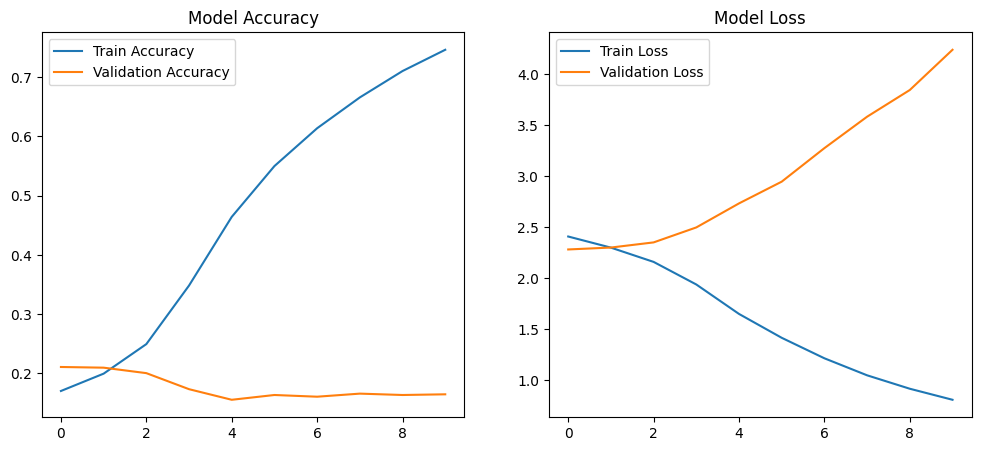

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.legend()

plt.show()


In [45]:
model.save("mbti_lstm_model.h5")


In [48]:
def predict_mbti(text):
    text_cleaned = clean_text(text)
    text_seq = tokenizer.texts_to_sequences([text_cleaned])
    text_pad = pad_sequences(text_seq, maxlen=MAX_LENGTH)
    
    prediction = model.predict(text_pad)[0]
    label = np.argmax(prediction)
    confidence = prediction[label]
    
    return label_encoder.inverse_transform([label])[0], confidence

print("Enter text to predict MBTI type:")
user_input = input()
predicted_type, confidence = predict_mbti(user_input)
print(f"Predicted MBTI Type: {predicted_type} with {confidence:.4f} confidence")


Enter text to predict MBTI type:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted MBTI Type: ENTP with 0.7071 confidence
